In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
import os
import pickle
import pandas as pd
from inference_weather import download_weather_for_inference
from output_utils import plot_heatmap_on_map, extract_year_month
#from inference_ndvi import download_ndvi_for_inference
import geopandas
import matplotlib.pyplot as plt
import xgboost as xgb
import hopsworks
from dateutil.relativedelta import relativedelta
import datetime

In [245]:
save = False

In [254]:
project = hopsworks.login(api_key_value=os.getenv('HOPSWORKS_API_KEY'))
fs = project.get_feature_store() 
mr = project.get_model_registry()

2026-01-06 06:57:29,064 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-06 06:57:29,066 INFO: Initializing external client


2026-01-06 06:57:29,066 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-06 06:57:30,254 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286351


# Download data features from Hopsworks

In [182]:
weather_fg = fs.get_feature_group(name='weather', version=2)
ndvi_fg = fs.get_feature_group(name='ndvi', version=2)

### Pre filtering: data from last and this month

In [ ]:
last_month = datetime.datetime.now() - datetime.timedelta(40)

batch_weather = weather_fg.filter(
    weather_fg.month >= last_month
).read()

batch_weather.month = pd.to_datetime(batch_weather.month.dt.date)
print(f"Points: {len(batch_weather)}")
batch_weather.head(3)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.34s) 


,month,lat,lon,ssrd_lag1,ssrd_lag2,ssrd_lag3,swvl1_lag1,swvl1_lag2,swvl1_lag3,swvl2_lag1,swvl2_lag2,swvl2_lag3,t2m_lag1,t2m_lag2,t2m_lag3,tp_lag1,tp_lag2,tp_lag3
0,2025-12-01,60.220414,13.266561,775036.0,4878465.0,9718889.0,0.257935,0.253586,0.246521,0.259689,0.244614,0.237244,271.43604,281.63600,287.25806,0.001204,0.001881,0.003781
1,2025-12-01,59.057392,15.641483,1695520.0,4310625.0,9844729.0,0.272049,0.251175,0.248291,0.274429,0.250381,0.242844,277.42432,280.95435,286.94556,0.002885,0.002421,0.003828
2,2025-12-01,58.957607,15.751089,977812.0,4503181.0,7837959.0,0.266617,0.286301,0.263184,0.267303,0.277847,0.264557,275.04150,281.93090,285.93580,0.001865,0.002577,0.003385
3,2025-12-01,59.522672,18.331208,1914200.0,4817593.0,9718889.0,0.283768,0.239807,0.246521,0.286652,0.235733,0.237244,278.08057,280.86646,287.25806,0.002425,0.002061,0.003781
4,2025-12-01,59.055183,15.633617,1695520.0,4576569.0,9844729.0,0.272049,0.450211,0.248291,0.274429,0.445725,0.242844,277.42432,281.39380,286.94556,0.002885,0.001658,0.003828


In [217]:
batch_ndvi = ndvi_fg.filter(
    ndvi_fg.month >= last_month
).read()

batch_ndvi.month = pd.to_datetime(batch_ndvi.month.dt.date)
print(f"Points: {len(batch_ndvi)}")
batch_ndvi.head(3)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.54s) 
Points: 7936


,lat,lon,month,ndvi_lag1,ndvi_lag2
0,59.056458,11.814901,2025-12-01,0.45380,0.7945
1,59.061217,15.656210,2025-12-01,0.65035,0.6828
2,59.054649,15.630866,2025-12-01,0.70415,0.6753


### Filter data up to last month available

In [225]:
batch_weather = batch_weather[batch_weather.month == batch_weather.month.max()]
print(f"Points: {len(batch_weather)}")

batch_ndvi = batch_ndvi[batch_ndvi.month == batch_ndvi.month.max()]
print(f"Points: {len(batch_ndvi)}")

assert batch_weather.month[0] == batch_ndvi.month[0], "Month mismatch "

Points: 13242
Points: 7936


# Download model from Hopsworks

In [ ]:
def get_model(mr, model_name='xgboost_model'):

    # retrieved_model = mr.get_model(
    #     name=model_name,
    #     version=3,
    # )

    all_models = mr.get_models(name='xgboost_model')

    # filter to find version 3
    retrieved_model = None
    for model in all_models:
        if model.version == 3:
            retrieved_model = model
            break

    if retrieved_model is None:
        raise ValueError(f"Model '{model_name}' version 3 not found")    
    
    fv = retrieved_model.get_feature_view()

    # Download the saved model artifacts to a local directory
    saved_model_dir = retrieved_model.download()

    return fv, saved_model_dir

fv, saved_model_dir = get_model(mr)
model = pickle.load(open(saved_model_dir + "/xgboost_model", "rb"))

2026-01-06 06:42:48,627 INFO: There is no parent information


Downloading: 100.000%|██████████| 894473/894473 elapsed<00:00 remaining<00:00

### Prepare dataset

In [238]:
dataset = batch_ndvi.merge(batch_weather, on=['lat', 'lon', 'month'], how='left')
dataset.dropna(inplace=True)

X = dataset.copy()
non_feature_cols = ["month", "lat", "lon"]
X.drop(columns = non_feature_cols, inplace=True)

X = (X - X.mean(axis=0)) / X.std(axis=0)
X


,ndvi_lag1,ndvi_lag2,ssrd_lag1,ssrd_lag2,ssrd_lag3,swvl1_lag1,swvl1_lag2,swvl1_lag3,swvl2_lag1,swvl2_lag2,swvl2_lag3,t2m_lag1,t2m_lag2,t2m_lag3,tp_lag1,tp_lag2,tp_lag3
5,-0.150290,0.281072,-0.914230,-1.530680,-2.830696,-0.206353,0.795340,-0.641992,-0.165301,0.612710,-0.806867,-0.285181,1.938987,2.439729,-2.297743,-2.548977,-2.200836
10,1.197978,0.810397,-0.937316,-1.536497,-2.830696,-0.368823,-0.892949,-0.641992,-0.344314,-1.098500,-0.806867,-0.836714,1.996643,2.439729,-2.280444,-2.498955,-2.200836
12,-1.056447,0.372754,-0.947181,-1.590858,-2.830696,-0.299687,-0.347471,-0.641992,-0.315650,-0.360406,-0.806867,-0.939409,1.735397,2.439729,-2.262001,-2.490752,-2.200836
13,0.952455,0.542796,-0.770757,-1.567920,-2.837657,0.025541,-0.762292,-0.262899,0.086499,-0.826063,-0.401248,1.156945,1.841565,2.514599,-2.198254,-2.563442,-2.199506
15,0.394122,-1.276345,-0.907502,-1.534477,-2.830696,-0.234872,-0.387312,-0.641992,-0.179071,-0.586365,-0.806867,-0.164784,1.915529,2.439729,-2.299930,-2.548641,-2.200836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7931,0.107256,0.338275,-0.151581,-0.084149,-0.476957,-0.396517,-0.371112,-0.172883,-0.525663,-0.406893,-0.110421,-0.112402,0.023729,-0.490694,-0.022528,-0.232480,0.832801
7932,0.463307,1.146956,-0.534416,-0.362578,-0.359508,-0.275211,-0.262289,-0.293540,-0.389850,-0.314122,-0.301936,-0.191821,-0.281097,-0.004117,-0.547995,-0.386587,-0.035883
7933,1.256617,-0.250997,1.686571,1.768718,1.642986,-0.326368,-0.503126,-0.862562,-0.232456,-0.537997,-0.964973,1.129632,1.069934,1.092820,-1.436399,-1.466484,-1.287566
7934,0.475541,0.621548,0.172049,0.193577,0.667070,0.083978,-0.234117,-0.423615,0.117324,-0.229663,-0.351205,0.710574,0.723767,0.469600,-0.062170,0.113620,-1.201184


# Load Model and Run Inference

In [239]:
dataset['pressence_prob'] = model.predict_proba(X[model.feature_names_in_.tolist()])[:,1]
dataset['pressence_pred'] = (dataset['pressence_prob'] > 0.95).astype(int)
dataset

,lat,lon,month,ndvi_lag1,ndvi_lag2,ssrd_lag1,ssrd_lag2,ssrd_lag3,swvl1_lag1,swvl1_lag2,...,swvl2_lag2,swvl2_lag3,t2m_lag1,t2m_lag2,t2m_lag3,tp_lag1,tp_lag2,tp_lag3,pressence_prob,pressence_pred
5,61.110833,14.611648,2025-12-01,0.30160,0.634300,730316.0,4921551.0,9718889.0,0.259445,0.315186,...,0.307205,0.237244,270.904800,281.751220,287.258060,0.001237,0.001878,0.003781,0.172068,0
10,55.585822,13.395413,2025-12-01,0.62120,0.769400,576880.0,4855541.0,9718889.0,0.250839,0.227249,...,0.217880,0.237244,268.471200,282.034420,287.258060,0.001499,0.002366,0.003781,0.242513,0
12,59.063046,15.654442,2025-12-01,0.08680,0.657700,511312.0,4238635.0,9718889.0,0.254501,0.255661,...,0.256409,0.237244,268.018070,280.751220,287.258060,0.001779,0.002446,0.003781,0.159047,0
13,59.808688,18.493850,2025-12-01,0.56300,0.701100,1683884.0,4498939.0,9567657.0,0.271729,0.234055,...,0.232101,0.259171,277.268070,281.272700,287.488530,0.002746,0.001737,0.003806,0.497413,0
15,60.220414,13.266561,2025-12-01,0.43065,0.236800,775036.0,4878465.0,9718889.0,0.257935,0.253586,...,0.244614,0.237244,271.436040,281.636000,287.258060,0.001204,0.001881,0.003781,0.211971,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7931,63.000000,14.000000,2025-12-01,0.36265,0.648900,5799118.0,21337310.0,60851100.0,0.249372,0.254430,...,0.253982,0.274892,271.667175,272.343781,278.237488,0.035758,0.024485,0.061154,0.049889,0
7932,64.300000,18.900000,2025-12-01,0.44705,0.855300,3254676.0,18177588.0,63402528.0,0.255798,0.260098,...,0.258825,0.264539,271.316742,270.846527,279.735291,0.027785,0.022981,0.044725,0.103804,0
7933,57.300000,15.200000,2025-12-01,0.63510,0.498500,18016044.0,42364300.0,106904368.0,0.253088,0.247554,...,0.247138,0.228697,277.147552,277.482574,283.111938,0.014306,0.012442,0.021053,0.228572,0
7934,60.900000,15.800000,2025-12-01,0.44995,0.721200,7950064.0,24489040.0,85703728.0,0.274824,0.261565,...,0.263233,0.261876,275.298492,275.782257,281.193512,0.035157,0.027863,0.022687,0.017703,0


In [ ]:
if save:
    month = pd.Timestamp(dataset.month.unique()[0])
    dataset.to_csv('../data/predictions/pressence_'+ str(month.day) + '_' + str(month.month) + '_' + str(month.year) + '_.csv', index=False)

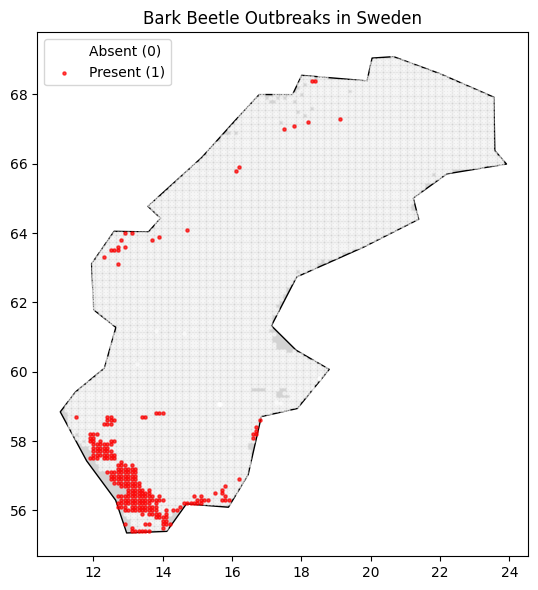

In [250]:
plot_heatmap_on_map(dataset, 'inference', title='Bark Beetle Outbreaks in Sweden')

# Add to Hopsworks

In [255]:
# Retrieve feature groups
beetle_features = fs.get_or_create_feature_group(
    name='predictions',
    description='Predictions of Spuce Bark Beetle in Sweden',
    version=2,
    primary_key=['lat','lon','month'],
    event_time="month"
)

beetle_features.insert(dataset, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286351/fs/1273971/fg/1908097


Uploading Dataframe: 100.00% |██████████| Rows 7814/7814 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286351/jobs/named/predictions_2_offline_fg_materialization/executions
2026-01-06 06:57:51,720 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2026-01-06 06:57:54,909 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2026-01-06 06:57:58,085 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2026-01-06 06:59:53,371 INFO: Waiting for log aggregation to finish.
2026-01-06 07:00:02,109 INFO: Execution finished successfully.


(Job('predictions_2_offline_fg_materialization', 'SPARK'), None)